In [6]:
import sys
import os
sys.path.append("../src/")
import combat
import numpy as np
import scipy.stats as stats
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import sklearn
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sb
import pickle as pkl
from sklearn.linear_model import LogisticRegression, Lasso, Ridge, ElasticNet
import random as rd
import matplotlib
matplotlib.rcParams['figure.dpi'] = 500
from sklearn.preprocessing import quantile_transform,binarize
from sklearn.model_selection import LeaveOneOut,KFold
from sklearn.metrics import r2_score
from statsmodels.stats.multitest import multipletests
from sklearn.cross_decomposition import PLSRegression as PLS
import warnings
warnings.simplefilter("ignore")
from multiprocessing import Process,Queue,Pool
import time 
import helper
from multiprocessing import set_start_method
#set_start_method("spawn")
from DecoID.DecoID import flatten
from sklearn.cross_decomposition import PLSRegression
from sklearn.svm import SVC
import importlib
import helper#import the module here, so that it can be reloaded.
importlib.reload(helper)
from statsmodels.stats.anova import AnovaRM


In [7]:
relevantRatios = [[["pHILICpos_197_Kynurenine"],["pHILICpos_183_DL Tryptophan"]],
                  [["pHILICneg_51_D   Glutamine"],["pHILICneg_84_L Glutamic acid"]],
                 [["pHILICpos_208_L Valine","pHILICpos_211_Leucine","pHILICneg_76_ISOLEUCINE"],
                      ["pHILICneg_113_Phenylalanine","pHILICpos_207_L Tyrosine"]]]

In [8]:
#load in metadata and peak areas and associate

#read in peak data
datafilename = "../data/QTof-B1-8_pHILIC_HSS_pos-neg_forMPP_normalized.csv"
data = pd.read_csv(datafilename)

#get area columns
areaCols = data.columns.values[5:]

#get molecule names
mol_names = data["Compound Name"].values

#extract area data and transpose
areaData = data[areaCols].transpose()

#get batch information
batchInfo = [int(x.split("_")[0][1]) for x in list(areaData.index.values)]

areaData = areaData.to_numpy()
areaData = areaData.astype(np.float)

#get index of blanks
blankSamp = [x for x in range(len(areaCols)) if "Blank" in areaCols[x] and not "equil" in areaCols[x]]
print(len(blankSamp)," blanks")

#get index of qc
qcSamp = [x for x in range(len(areaCols)) if "NIST" in areaCols[x] and not "equil" in areaCols[x] ]
print(len(qcSamp)," qc samples")

#get index of wu350 samples
samp = [x for x in range(len(areaCols)) if "WU350" in areaCols[x] and not "equil" in areaCols[x]]
print(len(samp), "research samples")

#load in metadata
metadatafn = "../data/Experiment-Parameters_b1-9.csv"
metadata = pd.read_csv(metadatafn)

#extact sample names for d0_yes samples
metadata_rel = metadata[metadata["day-COVID"] == "d0_Yes"]
print(len(metadata_rel)," d0 Covid+ Samples")

            
#create sample name, ventilator status linkage
vent_dict = {}
metadata_dict = {}
for index,row in metadata_rel.iterrows():
    val = str(row["ICU"])
    sampName = row["Sample General Name"]
    if "es" in val:
        val = 1
    elif "o" in val:
        val = 0
    vent_dict[sampName] = val
    metadata_dict[sampName] = row

print(np.sum(list(vent_dict.values()))," ICU+ samples")
print(len(vent_dict) - np.sum(list(vent_dict.values())),"ICU- samples")

#link vent status to sample in peak data
vent_status = []
metadata_for_samples = []
patient_ids = []
for s in np.array(areaCols)[samp]:
    tmp = s
    if tmp in vent_dict:
        vent_status.append(vent_dict[tmp])
        metadata_for_samples.append(metadata_dict[tmp])
        patient_ids.append(metadata_dict[tmp]["WU-350"])
    else:
        vent_status.append(-1)
        metadata_for_samples.append(-1)
print("found vent info for",len([x for x in vent_status if x != -1]),"covid_ d0 samples")
samplesOfInterest = [x for x in range(len(vent_status)) if vent_status[x] != -1]

sampleInfoDict = {}
for index,row in metadata.iterrows():
    if row["WU-350"] in patient_ids:
        val = str(row["ICU"])
        if "es" in val:
            val = 1
        elif "o" in val:
            val = 0
        
        sampleInfoDict[row["Sample General Name"]] = {"patient":row["WU-350"],"ICU":val,
                                                      "Day_to_ICU":row["Epic: Time from symptom onset to ICU (days)"],
                                                     "sample_day":row["WU350-Symptom onset"],
                                                      "death":row["Mortality Status"]}

index = 0
samplesOfInterest = []
for s in np.array(areaCols)[samp]:
    tmp = s
    if tmp in sampleInfoDict:
        samplesOfInterest.append(index)
        sampleInfoDict[tmp]["index"] = index
    index += 1
    
sampleInfoDict = {key:val for key,val in sampleInfoDict.items() if "index" in val}
sampleInfoDict = pd.DataFrame.from_dict(sampleInfoDict,orient="index")
print("found logitudinal info for: ",len(sampleInfoDict))

tmp = sampleInfoDict[sampleInfoDict["ICU"] == 1]
tmp = tmp[tmp["Day_to_ICU"] == "None"]
sampleInfoDict = sampleInfoDict.drop(tmp.index.values,axis=0)


#create sample matrix
samp_int = np.log2(areaData[samp])


print(samp_int.shape)

0  blanks
0  qc samples
616 research samples
264  d0 Covid+ Samples
123  ICU+ samples
141 ICU- samples
found vent info for 223 covid_ d0 samples
found logitudinal info for:  492
(616, 707)


[['pHILICpos_197_Kynurenine'], ['pHILICpos_183_DL Tryptophan']]
[['pHILICneg_51_D   Glutamine'], ['pHILICneg_84_L Glutamic acid']]
[['pHILICpos_208_L Valine', 'pHILICpos_211_Leucine', 'pHILICneg_76_ISOLEUCINE'], ['pHILICneg_113_Phenylalanine', 'pHILICpos_207_L Tyrosine']]


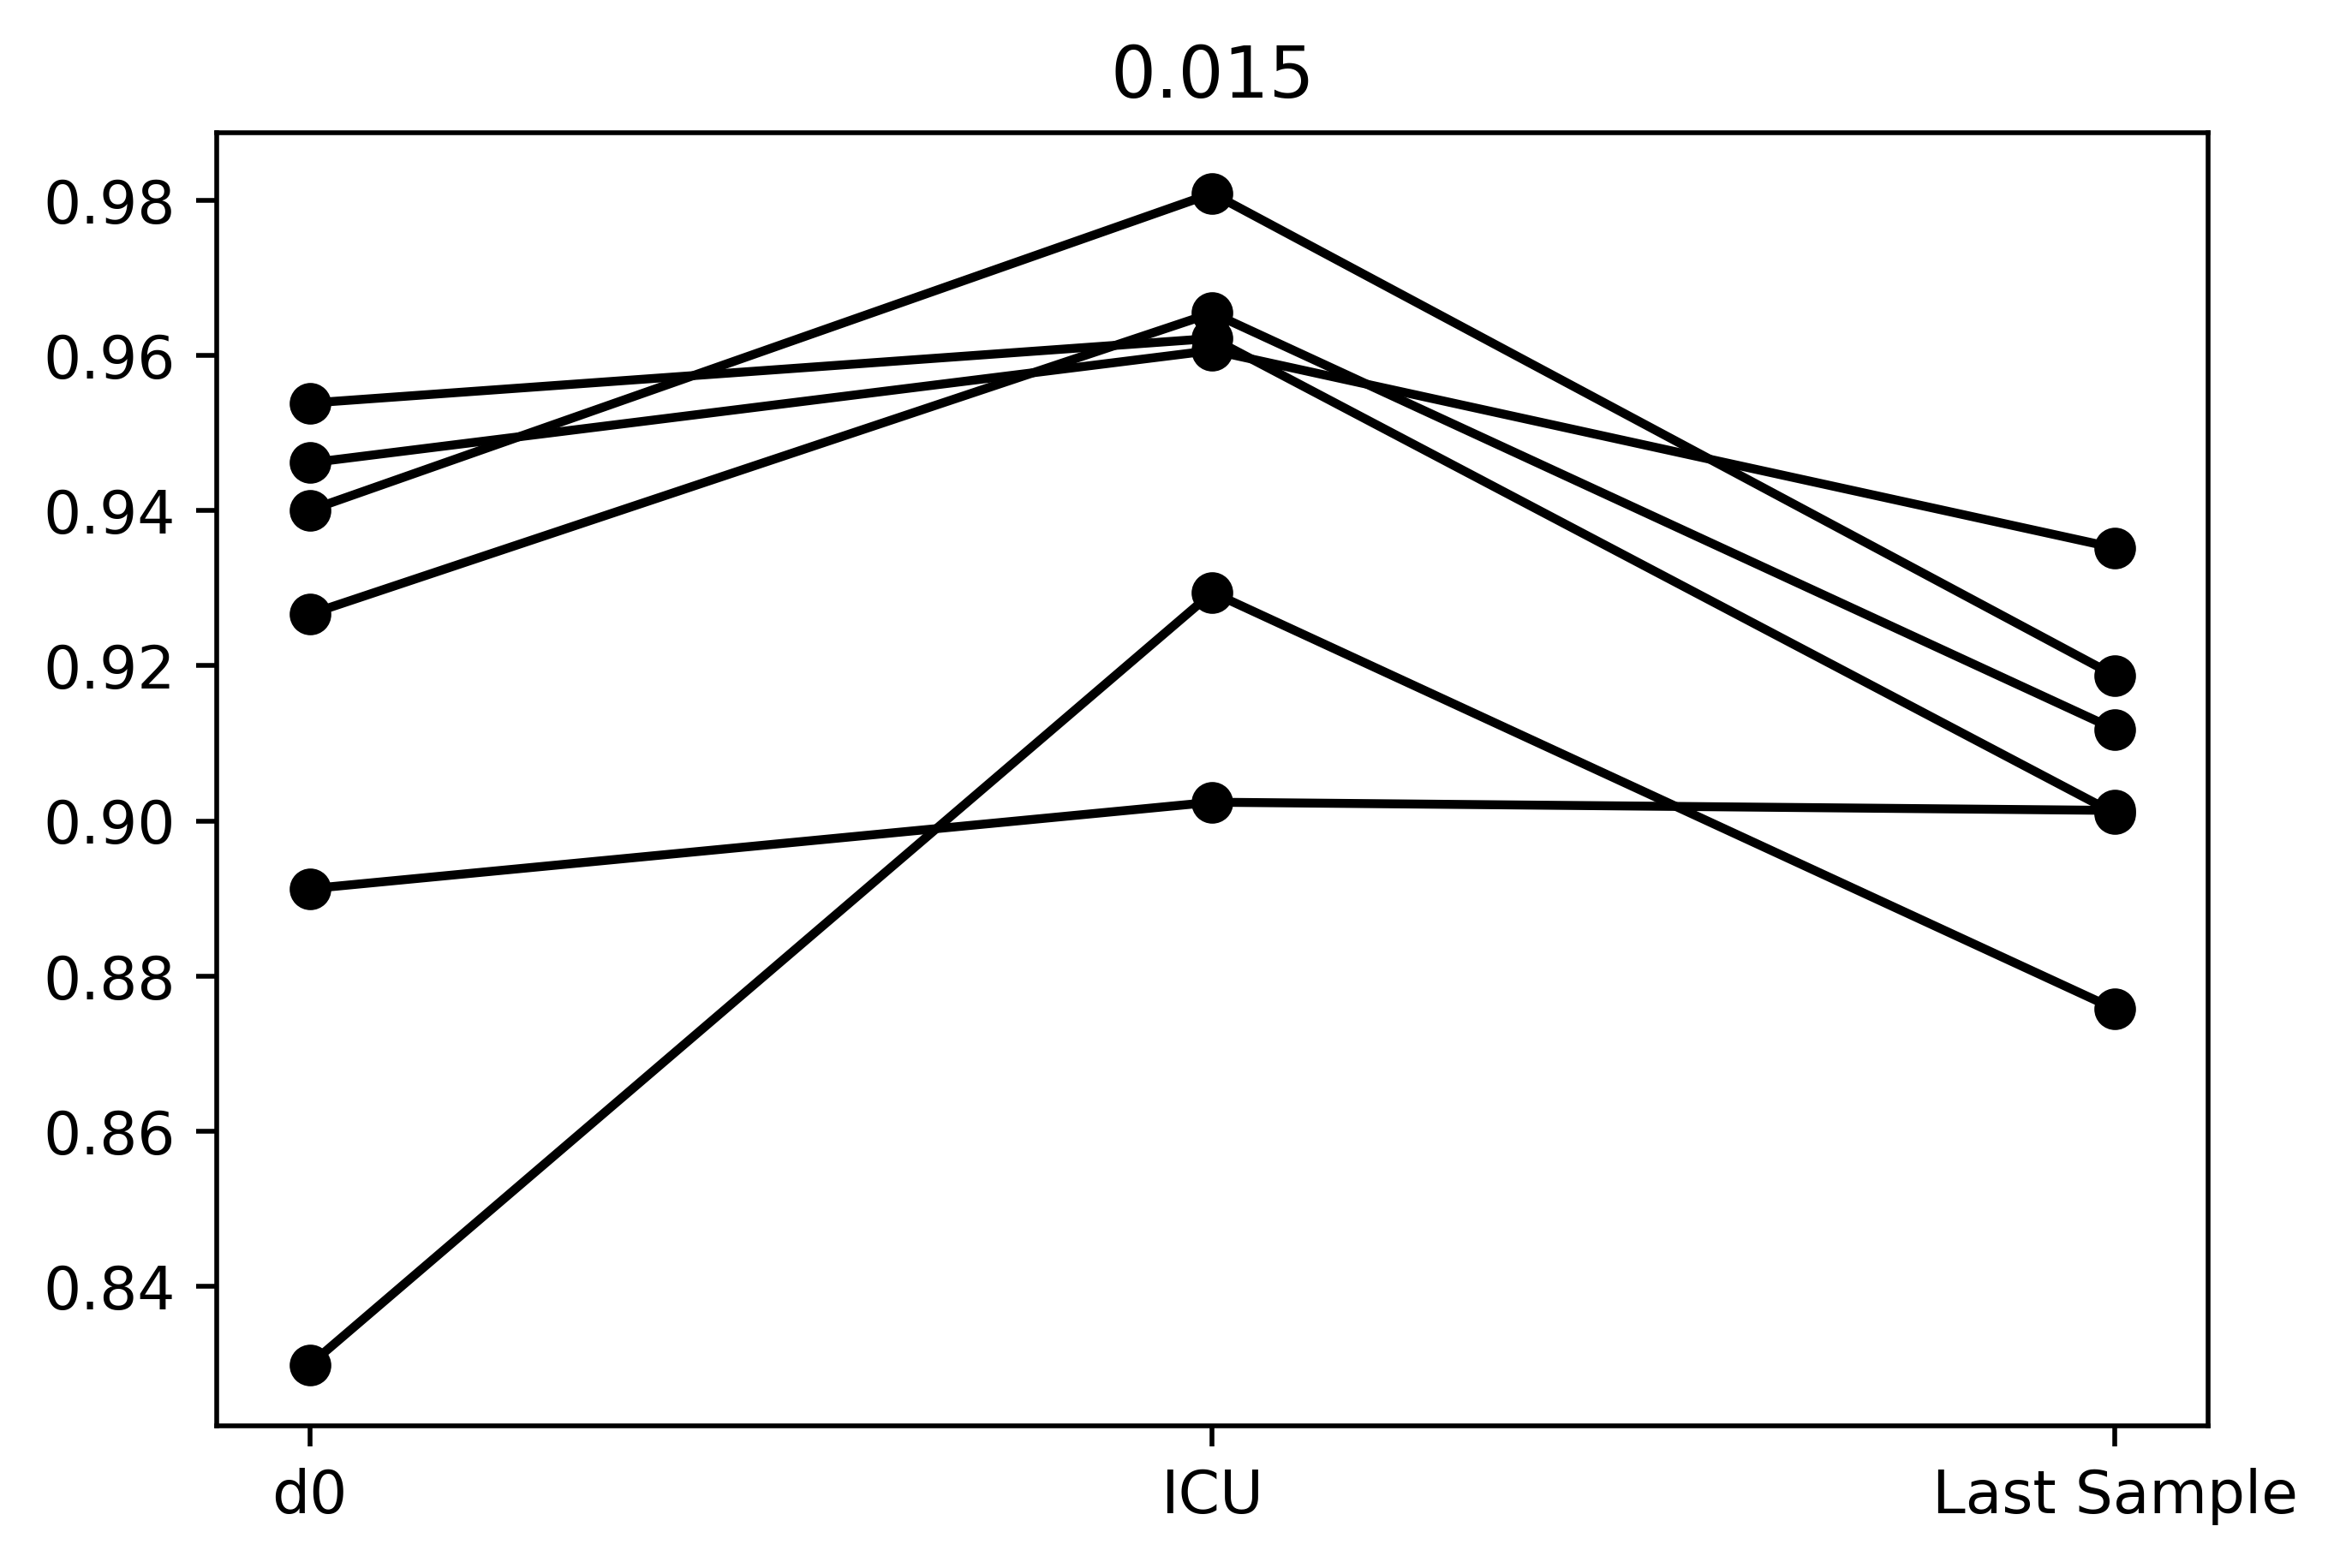

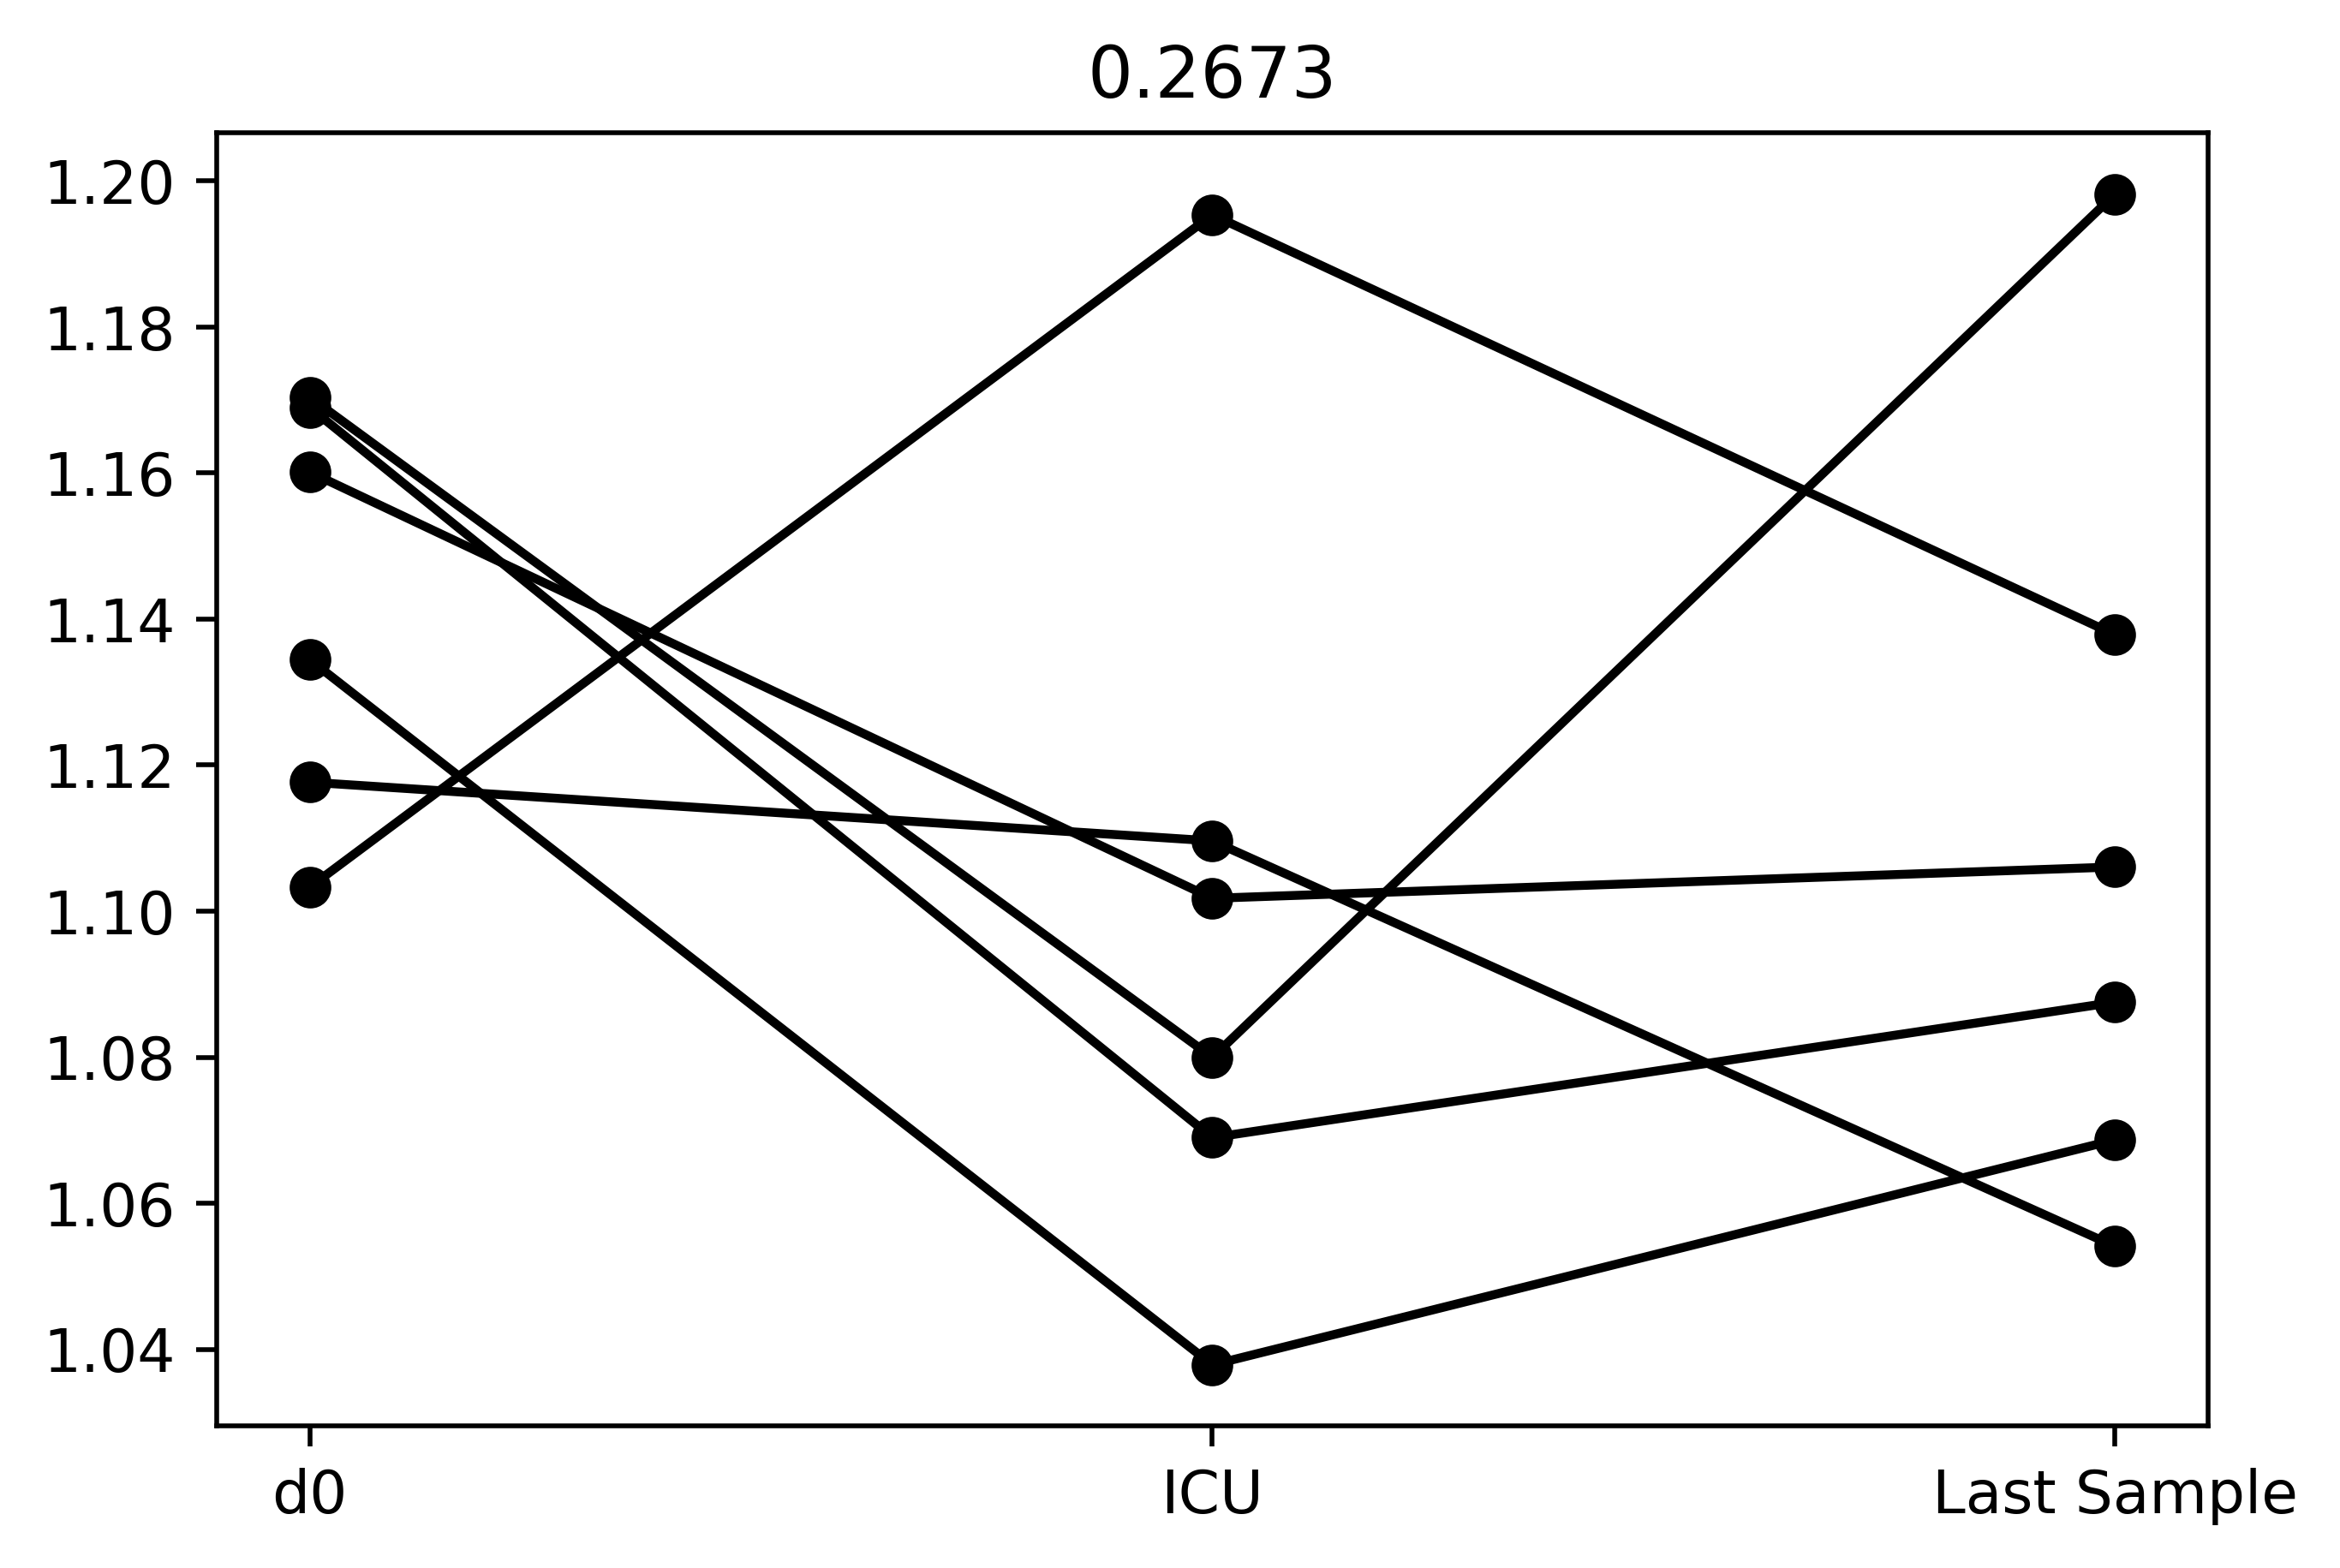

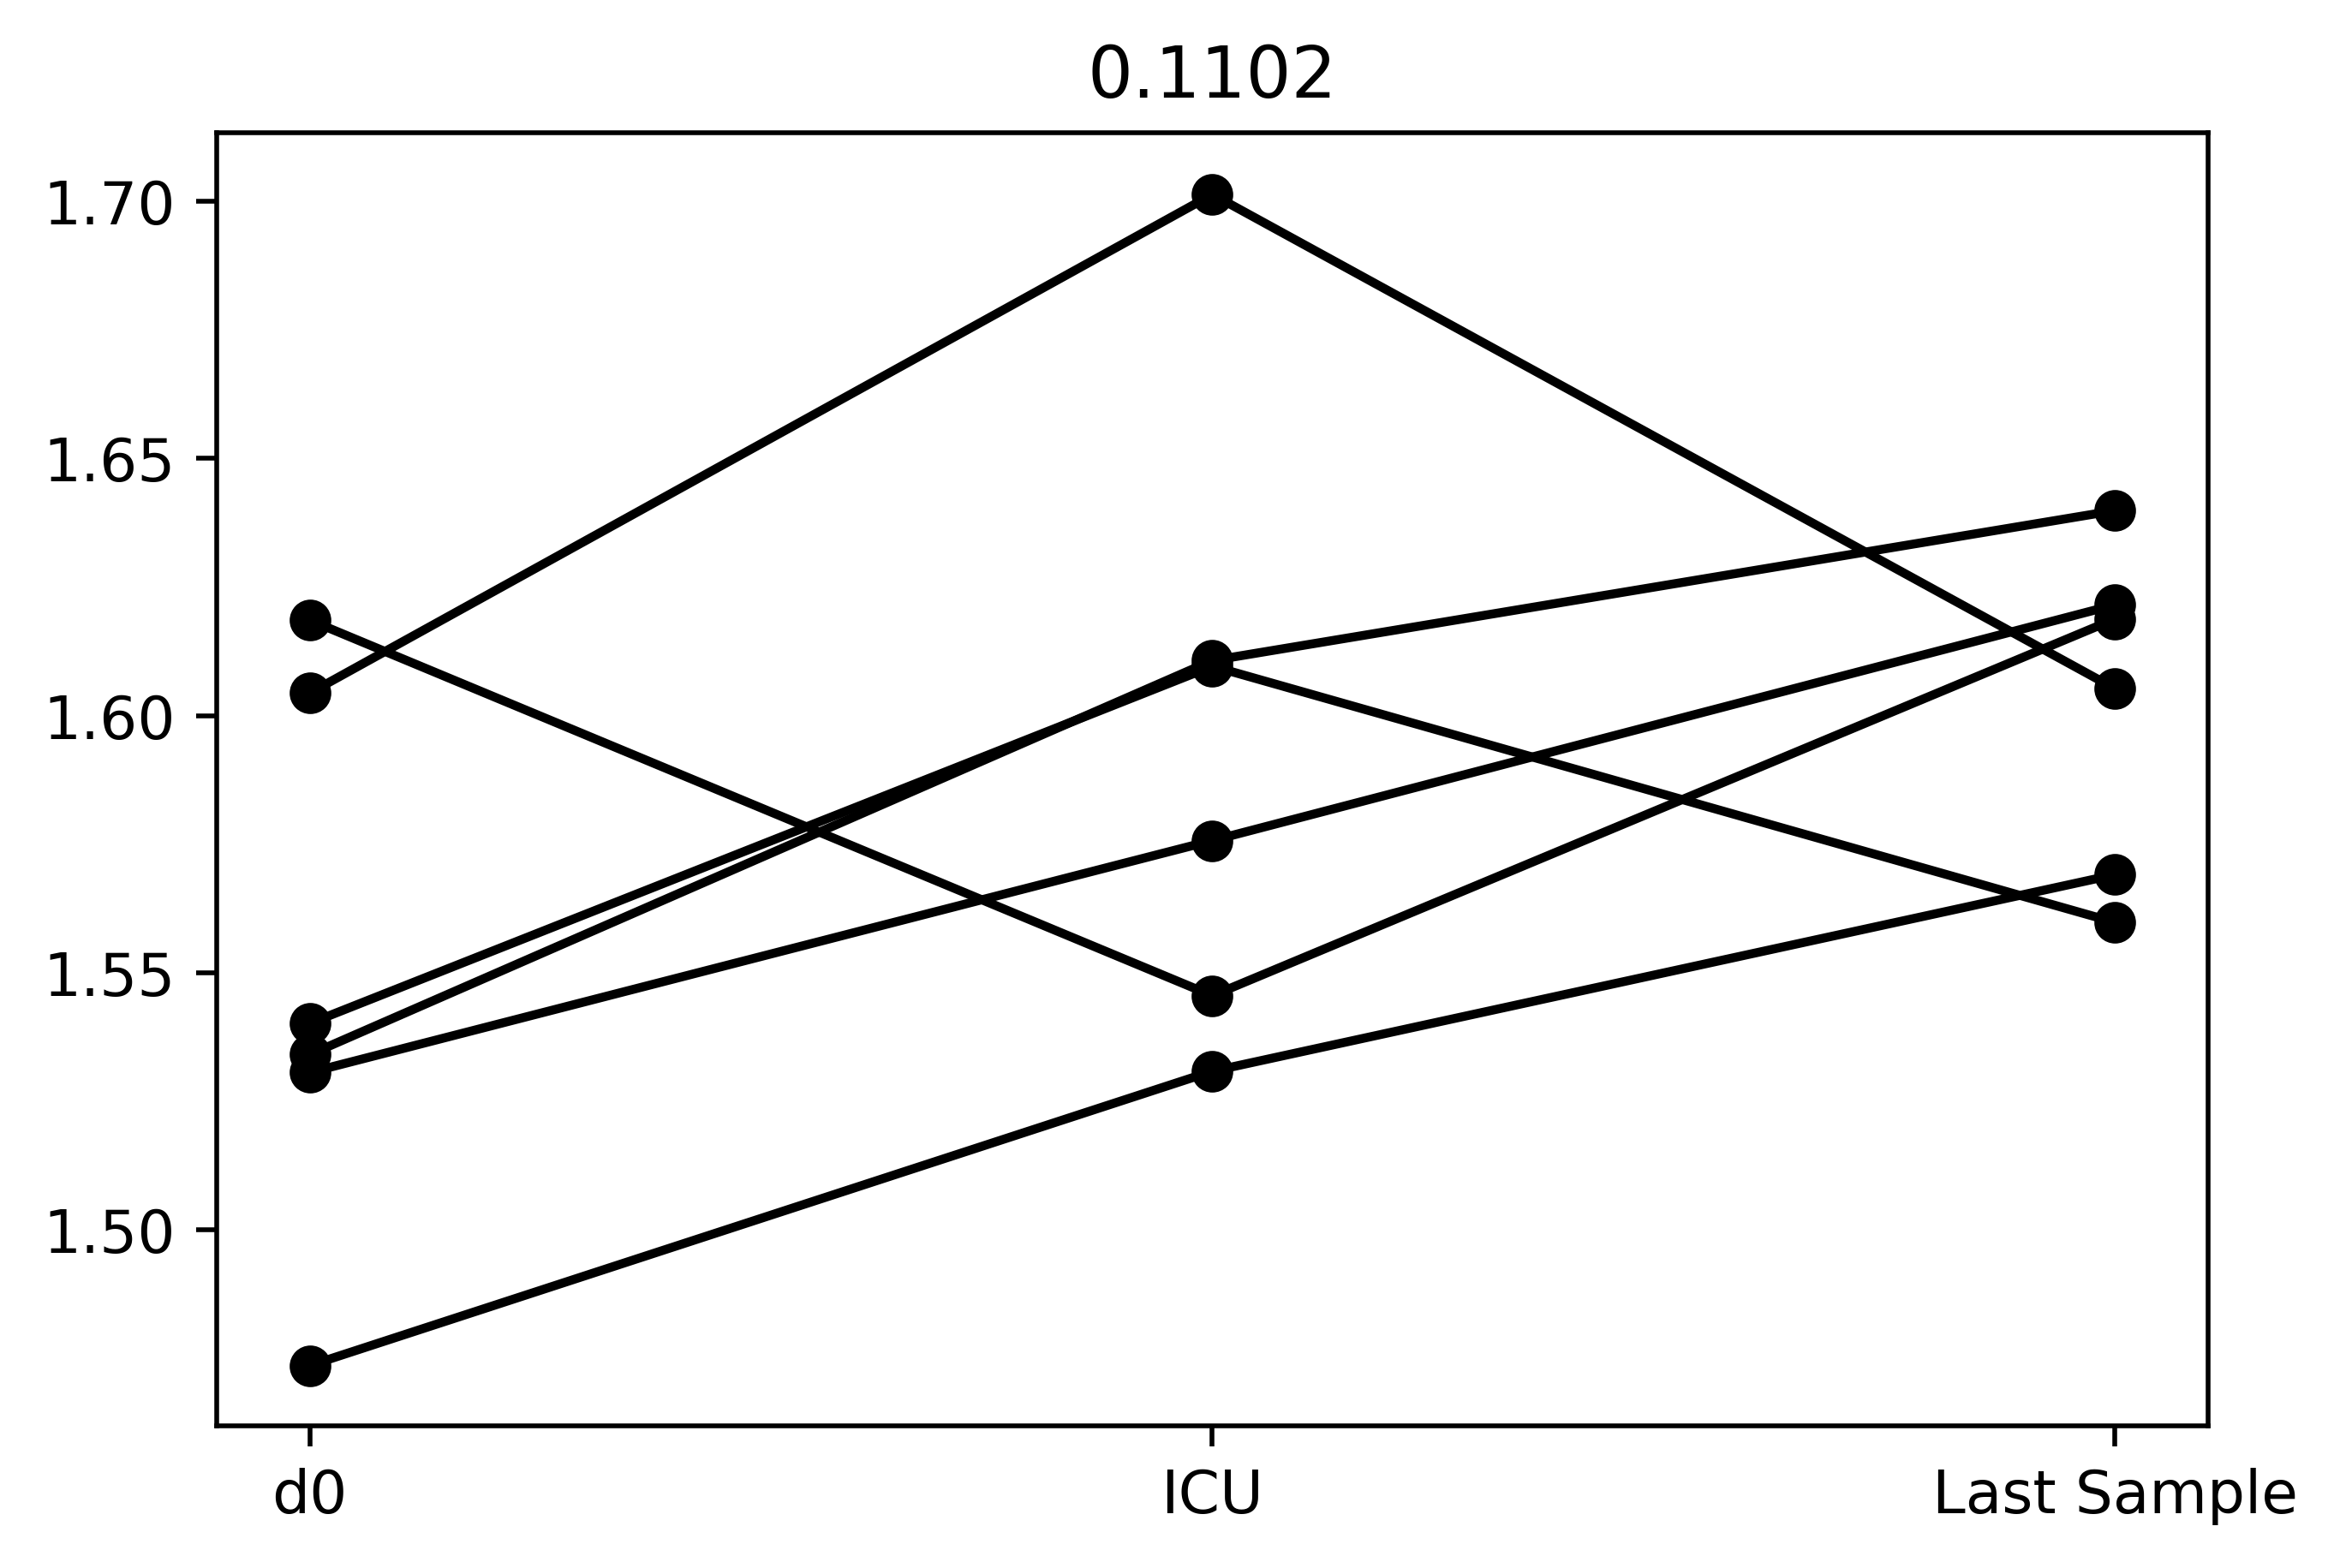

In [10]:
uniquePatients = list(set([x for x in sampleInfoDict["patient"]]))
goodPatients = [x for x in uniquePatients if len([y for y in sampleInfoDict["patient"].values if y == x]) > 2]
mol_name_to_index = {n:list(mol_names).index(n) for n in mol_names}

for ratio in relevantRatios:
    plt.figure()
    starts = []
    icus = []
    ends = []
    for pat in goodPatients:
        relsamples = [row["index"] for index,row in sampleInfoDict.iterrows() if row["patient"]==pat]
        times = [row["sample_day"] for index,row in sampleInfoDict.iterrows() if row["patient"]==pat]
        ICU = [row["ICU"] for index,row in sampleInfoDict.iterrows() if row["patient"]==pat][0]
        mort = [row["death"] for index,row in sampleInfoDict.iterrows() if row["patient"]==pat][0]
        if ICU and mort == "Alive":
            ICU_day = float([row["Day_to_ICU"] for index,row in sampleInfoDict.iterrows() if row["patient"]==pat][0])
            tmp = samp_int[relsamples,:]
            order = list(range(len(times)))
            order.sort(key=lambda x:times[x])
            tmp = tmp[order]
            #tmp = tmp - tmp[0]
            times = [times[x] for x in order]
            closestTime = times[0]
            err = np.inf
            for x in times:
                if np.abs(x-ICU_day) < err:
                    err = np.abs(x-ICU_day)
                    closestTime = x
            if closestTime != times[0] and closestTime != times[-1]:
                num_compounds,denom_compounds = ratio
                numerator = np.zeros((len(tmp),1))[:,0]
                for c in num_compounds:
                    numerator = np.add(numerator,tmp[:,mol_name_to_index[c]])
                denom = np.zeros((len(tmp),1))[:,0]
                for c in denom_compounds:
                    denom = np.add(denom,tmp[:,mol_name_to_index[c]])
                tmp = np.divide(numerator,denom)
                
                starts.append(tmp[0])
                icus.append(tmp[times.index(closestTime)])
                ends.append(tmp[-1])
                #tmp = tmp - tmp[0]
                plt.plot([0,1,2],[tmp[0],tmp[times.index(closestTime)],tmp[-1]],color="black")
                plt.scatter([0,1,2],[tmp[0],tmp[times.index(closestTime)],tmp[-1]],color="black")
    df = dict()
    ind = 0
    ps = 0
    for s,i,e in zip(starts,icus,ends):
        df[ind] = {"patient":ps,"time":"d0","val":s}
        ind += 1
        df[ind] = {"patient":ps,"time":"ICU","val":i}
        ind += 1
        df[ind] = {"patient":ps,"time":"end","val":e}
        ind += 1
        ps += 1
    p = AnovaRM(data=pd.DataFrame.from_dict(df,orient="index"),depvar="val",subject="patient",within = ["time"]).fit().anova_table["Pr > F"].values[0]
    plt.title(str(np.round(p,4)))
    plt.xticks([0,1,2],labels=["d0","ICU","Last Sample"])
    print(ratio)
